In [170]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.graph_objects as go
import tqdm


from tqdm.notebook import tqdm
from textblob import TextBlob
from collections import defaultdict
from matplotlib import pyplot as plt
from collections import Counter
from scipy import stats
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud, STOPWORDS

tqdm.pandas()

In [131]:
df = pd.read_csv('preprocessed_text.csv', index_col=0)
df.sample(10, random_state=228)

,text,label,text_lemmatized
1117214,new article : litecoin price analysis: ltc/usd...,1,"['new', 'article', 'litecoin', 'price', 'analy..."
969580,remember when we were bullied for being a joke,2,"['remember', 'bullied', 'joke']"
108860,"real price 2,48-2,49 on binance...",2,"['real', 'price', 'binance']"
288409,how can we get outbof this f**** algo trading?,2,"['get', 'outbof', 'f', 'algo', 'trading']"
418468,the email that started a revolution.,2,"['email', 'started', 'revolution']"
1001161,if anyone knows please,2,"['anyone', 'know', 'please']"
3194,bitcoin wasn’t created to make you rich.it was...,2,"['bitcoin', 'wasnt', 'created', 'make', 'richi..."
636651,i wnt hella % gains from reputable exchanges. ...,2,"['wnt', 'hella', 'gain', 'reputable', 'exchang..."
1182160,who here feels 70k besides this guy,2,"['feel', 'besides', 'guy']"
304296,was expecting more of a pop today. but i’ll t...,1,"['expecting', 'pop', 'today', 'ill', 'take']"


In [159]:
df['text_for_analysis'] = df.text_lemmatized.str.replace(r'(\[|\]| )', '', regex=True).str.\
                       replace("\'", "").\
                       progress_apply(lambda x: x.split(','))

  0%|          | 0/1326859 [00:00<?, ?it/s]

In [160]:
df['text_for_analysis'].sample(10)

686886                  [altcoin, account, recovered, spike]
372179                     [volume, billion, probably, sale]
835955     [crypto, moonbois, hodlers, bitcoin, maximalis...
77704      [hey, friend, would, evaluate, everythingmassi...
976128                             [sweet, baby, jesus, leg]
224491                                [knew, bad, idea, buy]
815855     [lithium, predominantly, huge, ev, related, in...
1116423                            [love, dont, sleep, folk]
603196                        [exciting, thing, hold, right]
36561      [analyst, writing, article, potential, decline...
Name: text_for_analysis, dtype: object

In [161]:
df['text_for_analysis'].loc[0]

['curious', 'price', 'chose', 'lowest', 'chamber', 'good', 'imo']

In [189]:
df.label.value_counts(normalize=True)

2    0.508060
1    0.398428
0    0.093512
Name: label, dtype: float64

In [190]:
df.label.value_counts(normalize=False)

2    674124
1    528658
0    124077
Name: label, dtype: int64

## Описательные статистики

In [58]:
df['twit_length'] = df.text_for_analysis.progress_apply(len)

  0%|          | 0/1326859 [00:00<?, ?it/s]

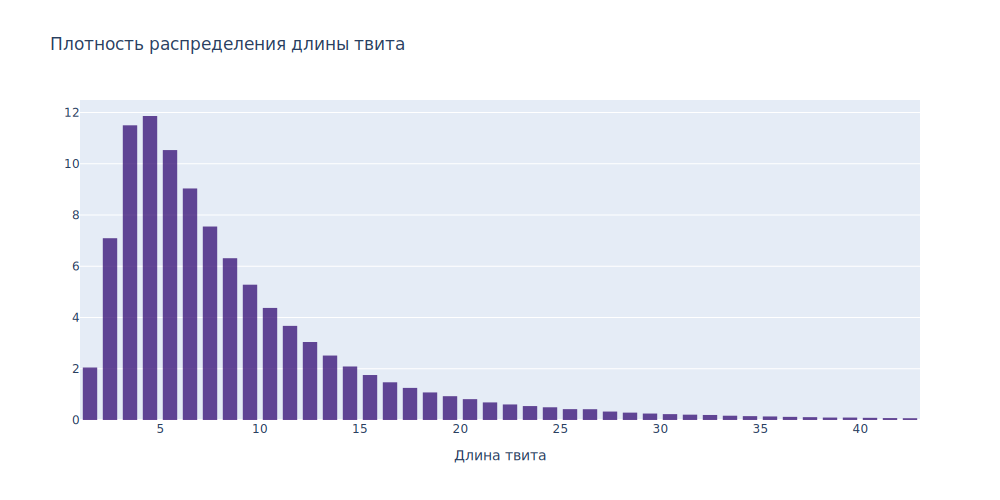

In [60]:
fig = go.Figure()
fig.add_trace(go.Histogram(
    x=df['twit_length'],
    histnorm='percent',
    name='experimental',
    xbins=dict(
        start=0,
        end=np.quantile(df['twit_length'], [.99])[0],
    ),
    marker_color='#330C73',
    opacity=0.75
))

fig.update_layout(
    title_text='Плотность распределения длины твита', # title of plot
    xaxis_title_text='Длина твита', # xaxis label
    bargap=0.2, # gap between bars of adjacent location coordinates
    bargroupgap=0.1 # gap between bars of the same location coordinates
)

fig.show('svg', height=500, width=1000)

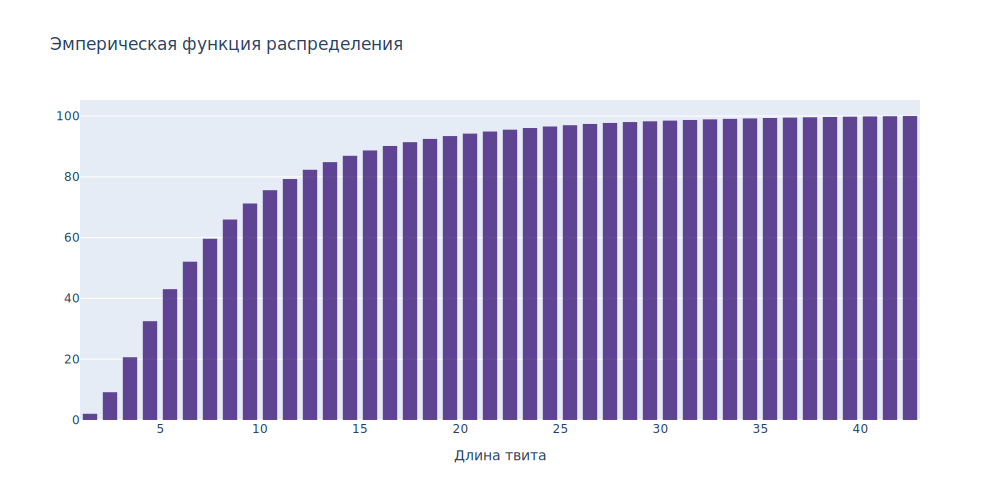

In [66]:
fig = go.Figure()
fig.add_trace(go.Histogram(
    x=df['twit_length'],
    histnorm='percent',
    name='experimental',
    cumulative_enabled=True,
    xbins=dict(
        start=0,
        end=np.quantile(df['twit_length'], [.99])[0],
    ),
    marker_color='#330C73',
    opacity=0.75
))

fig.update_layout(
    title_text='Эмперическая функция распределения', # title of plot
    xaxis_title_text='Длина твита', # xaxis label
    bargap=0.2, # gap between bars of adjacent location coordinates
    bargroupgap=0.1 # gap between bars of the same location coordinates
)

fig.show('svg', height=500, width=1000)

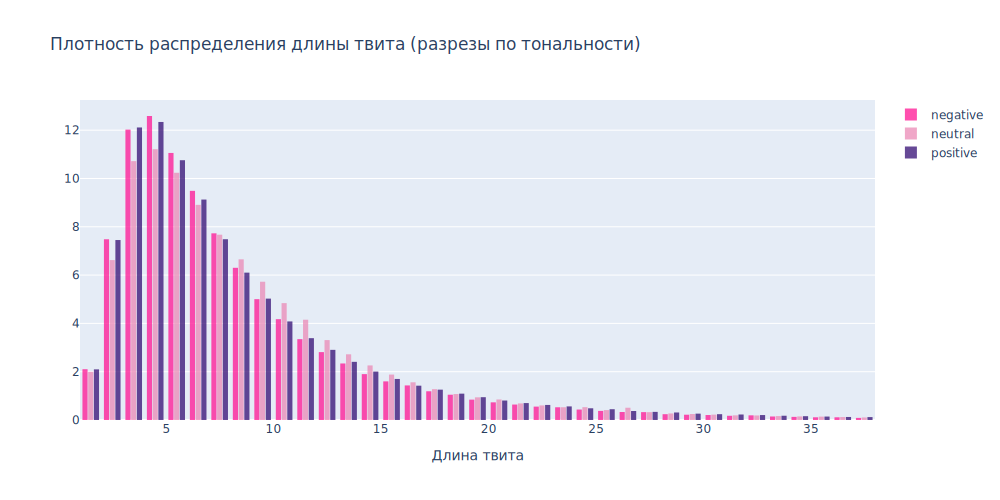

In [64]:
fig = go.Figure()
fig.add_trace(go.Histogram(
    x=df['twit_length'][df.label==0],
    histnorm='percent',
    name='negative',
    xbins=dict(
        start=0,
        end=np.quantile(df['twit_length'][df.label==0], [.99])[0],
    ),
    marker_color='deeppink',
    opacity=0.75
))
fig.add_trace(go.Histogram(
    x=df['twit_length'][df.label==1],
    histnorm='percent',
    name='neutral',
    xbins=dict(
        start=0,
        end=np.quantile(df['twit_length'][df.label==0], [.99])[0],
    ),
    marker_color='#EB89B5',
    opacity=0.75
))
fig.add_trace(go.Histogram(
    x=df['twit_length'][df.label==2],
    histnorm='percent',
    name='positive',
    xbins=dict(
        start=0,
        end=np.quantile(df['twit_length'][df.label==0], [.99])[0],
    ),
    marker_color='#330C73',
    opacity=0.75
))

fig.update_layout(
    title_text='Плотность распределения длины твита (разрезы по тональности)', # title of plot
    xaxis_title_text='Длина твита', # xaxis label
    bargap=0.2, # gap between bars of adjacent location coordinates
    bargroupgap=0.1 # gap between bars of the same location coordinates
)

fig.show('svg', height=500, width=1000)

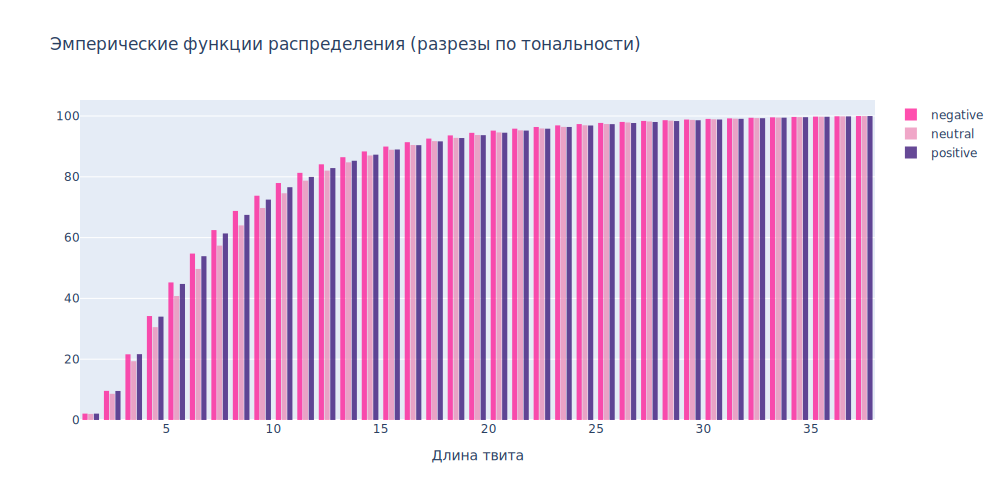

In [65]:
fig = go.Figure()
fig.add_trace(go.Histogram(
    x=df['twit_length'][df.label==0],
    histnorm='percent',
    name='negative',
    cumulative_enabled=True,
    xbins=dict(
        start=0,
        end=np.quantile(df['twit_length'][df.label==0], [.99])[0],
    ),
    marker_color='deeppink',
    opacity=0.75
))
fig.add_trace(go.Histogram(
    x=df['twit_length'][df.label==1],
    histnorm='percent',
    name='neutral',
    cumulative_enabled=True,
    xbins=dict(
        start=0,
        end=np.quantile(df['twit_length'][df.label==0], [.99])[0],
    ),
    marker_color='#EB89B5',
    opacity=0.75
))
fig.add_trace(go.Histogram(
    x=df['twit_length'][df.label==2],
    histnorm='percent',
    name='positive',
    cumulative_enabled=True,
    xbins=dict(
        start=0,
        end=np.quantile(df['twit_length'][df.label==0], [.99])[0],
    ),
    marker_color='#330C73',
    opacity=0.75
))

fig.update_layout(
    title_text='Эмперические функции распределения (разрезы по тональности)', # title of plot
    xaxis_title_text='Длина твита', # xaxis label
    bargap=0.2, # gap between bars of adjacent location coordinates
    bargroupgap=0.1 # gap between bars of the same location coordinates
)

fig.show('svg', height=500, width=1000)

In [67]:
#cтатистики по всему корпусу
df.twit_length.agg(['mean', 'std', 'median'])

mean      8.754991
std       8.534505
median    6.000000
Name: twit_length, dtype: float64

In [70]:
df.groupby('label').twit_length.agg(['mean', 'std', 'median'])

,mean,std,median
label,,,
0,8.219726,7.459060,6.0
1,8.932344,8.498363,7.0
2,8.714426,8.741138,6.0


In [77]:
res = stats.kstest(df['twit_length'][df['label'] == 0], df['twit_length'][df['label'] == 1])
print(f'KS-test p-value: {res.pvalue: .5f}')

KS-test p-value:  0.00000


In [78]:
res = stats.kstest(df['twit_length'][df['label'] == 0], df['twit_length'][df['label'] == 2])
print(f'KS-test p-value: {res.pvalue: .5f}')

KS-test p-value:  0.00000


In [80]:
res = stats.kstest(df['twit_length'][df['label'] == 1], df['twit_length'][df['label'] == 2])
print(f'KS-test p-value: {res.pvalue: .5f}')

KS-test p-value:  0.00000


### Средняя длина твита составляет ~8 cлов, медиана чуть меньше, это обусловлено скошенностью распределений вправо и толстым левым хвостом. Интересно, что распределения длины твитов по классам визуально почти не отличаются друг от друга, но при этом тест Колмогорова-Смирнова позволяет отвергнуть нулевую гипотезу о том, что выборки порождены одним распределением на любом разумном уровне значимости. 

In [106]:
def plot_top_words(data):
    corpus=[]
    new = data['text_for_analysis']
    new=new.values.tolist()
    corpus=[word for i in new for word in i]


    dic=defaultdict(int)
    for word in corpus:
        dic[word]+=1
        
    counter=Counter(corpus)
    most=counter.most_common()


    plt.figure(figsize=(10,8))
    x, y= [], []
    for word,count in most[:40]:
        if word not in ("\'>\'", "\'<\'", "\'number\'"):
            x.append(word)
            y.append(count)

    sns.barplot(x=y,y=x)
    plt.show()

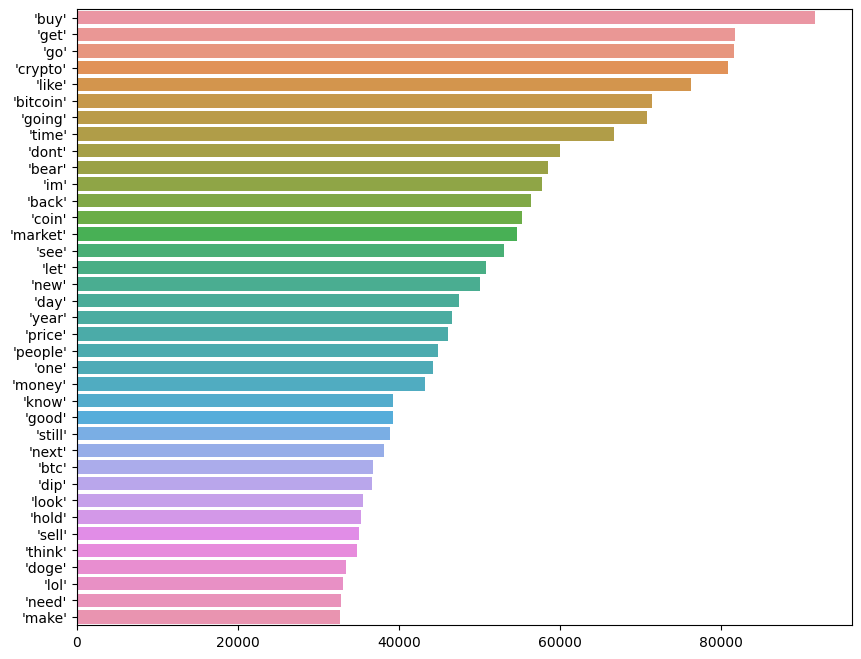

In [108]:
plot_top_words(df)

### Три самых популярных слова после очистки: "buy", "go", "get"

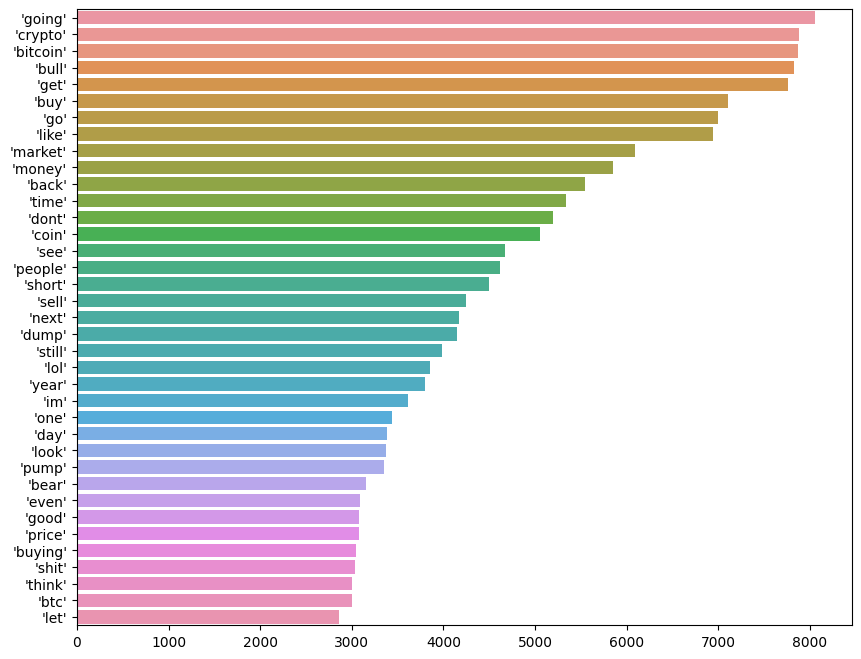

In [109]:
plot_top_words(df[df['label'] == 0])

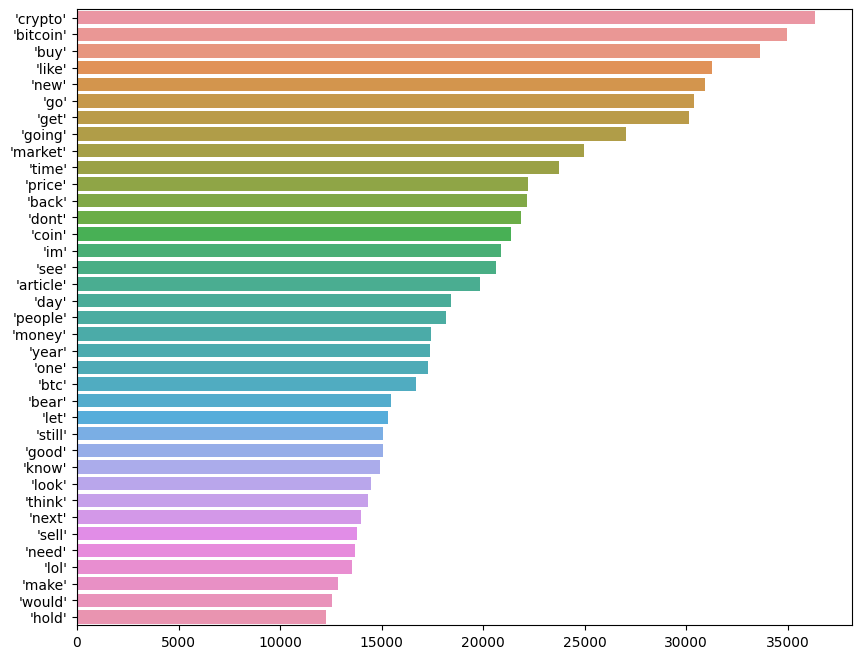

In [110]:
plot_top_words(df[df['label'] == 1])

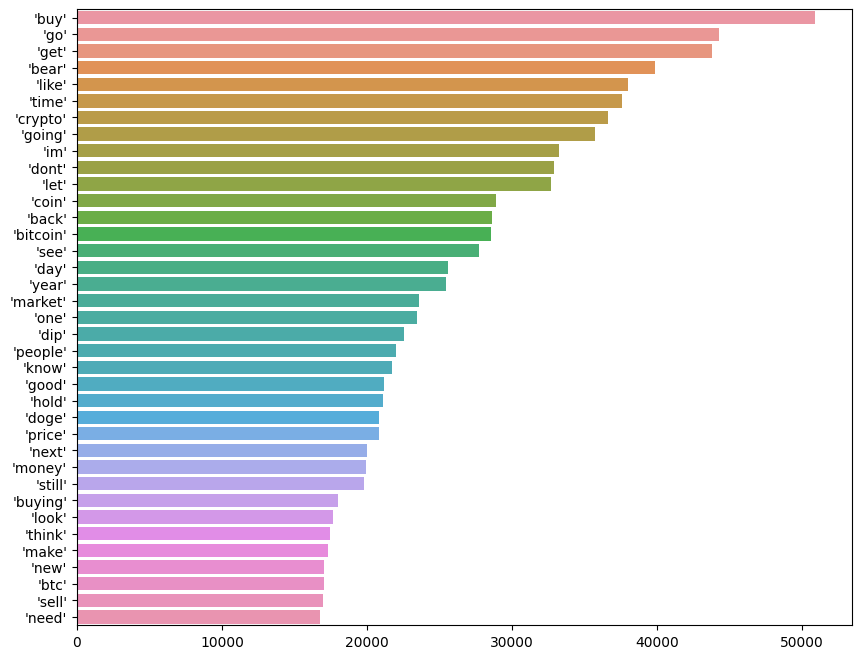

In [111]:
plot_top_words(df[df['label'] == 2])

### Топ слов в разрезе классов едва ли отличается. Также вызывает вопросы, что для класса 2 (отмечен как "bullish", означающий бычий рынок) "bear" входит в топ-4. 

In [134]:
def get_top_ngram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx])
                  for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    
    plt.figure(figsize=(10,8))
    top_n_bigrams = words_freq[:10]
    
    x,y=map(list,zip(*top_n_bigrams))
    sns.barplot(x=y,y=x)
    plt.show()

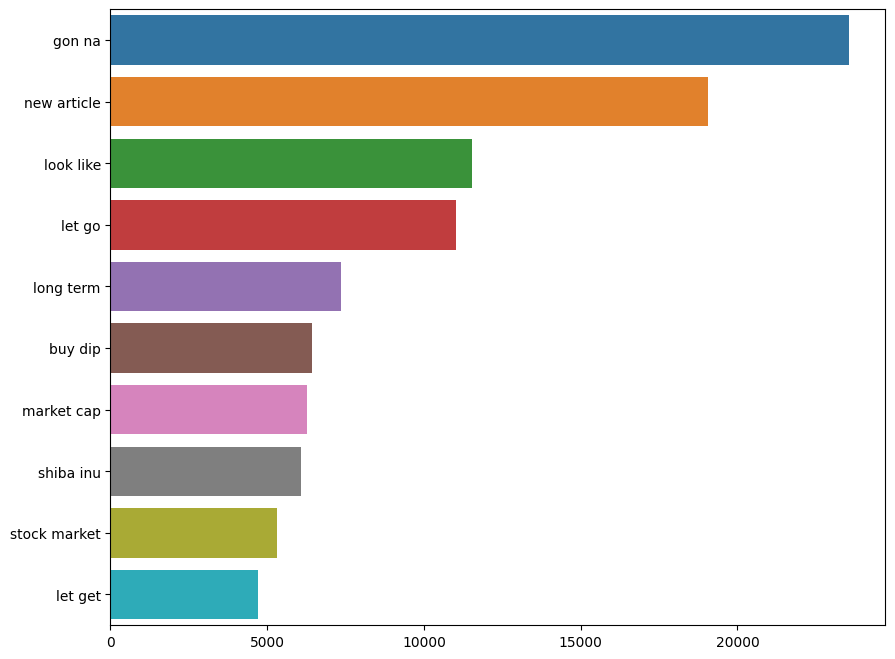

In [138]:
get_top_ngram(df['text_lemmatized'], 2)

### Видим упоминание конкретного коина (шиба ину), похоже на оверфит модели (которой размечали) под конкретную рыночную ситуацию

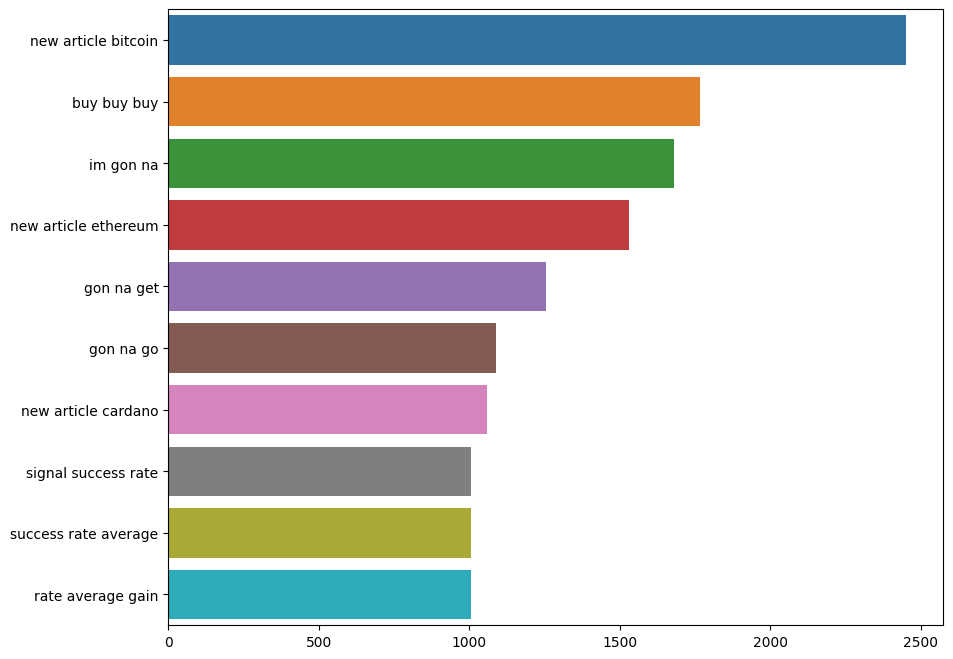

In [136]:
get_top_ngram(df['text_lemmatized'], 3)

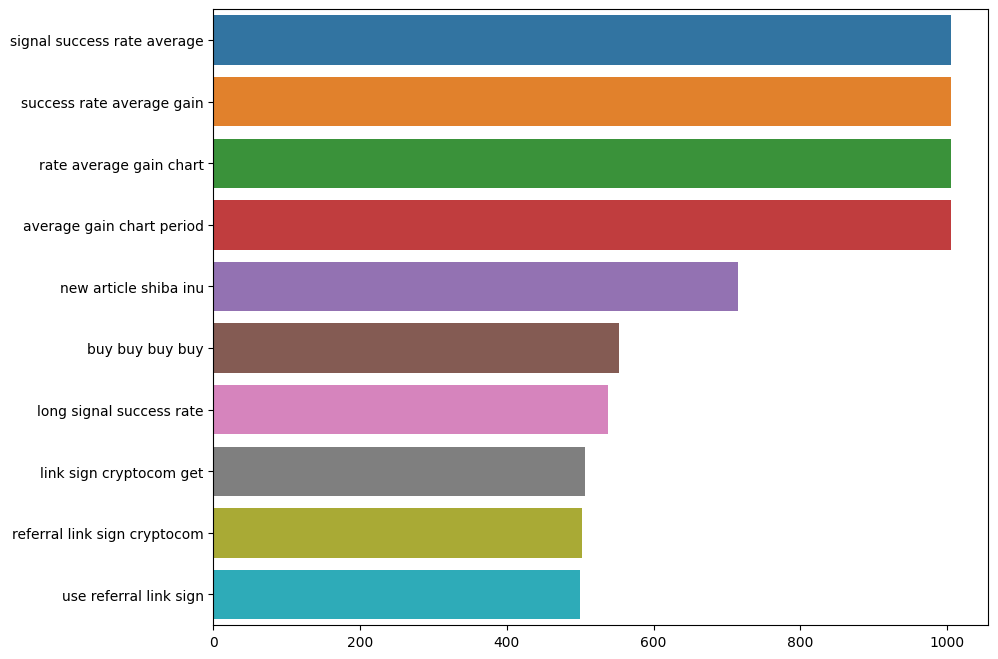

In [137]:
get_top_ngram(df['text_lemmatized'], 4)

### Построим 2 и 3-граммы под каждый класс

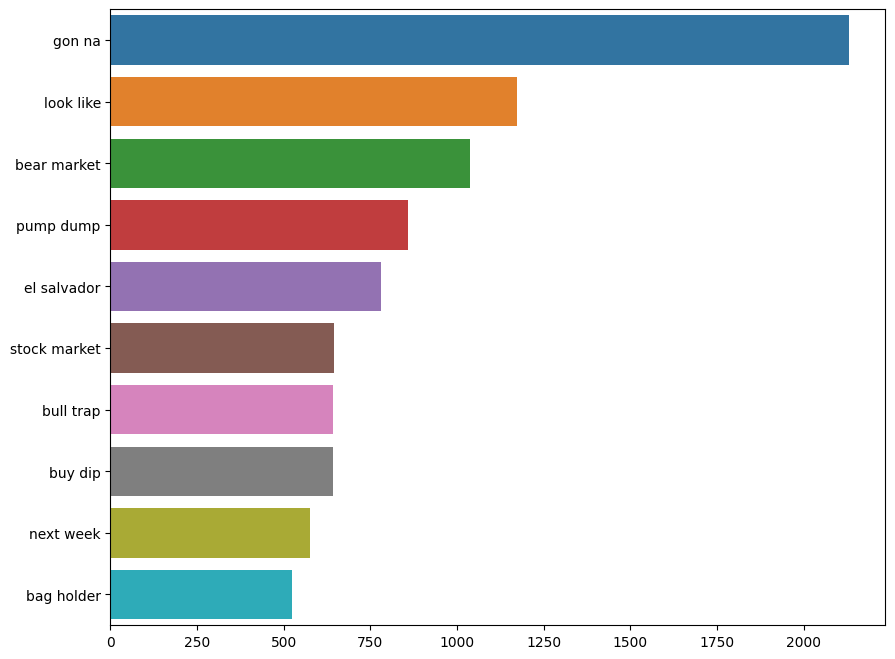

In [139]:
get_top_ngram(df['text_lemmatized'][df['label'] == 0], 2)

### Видим н-граммы соответсвующие медвежьему рынку: "бычья ловушка", "медвежий рынок", "покупаем ниже",  "держим"

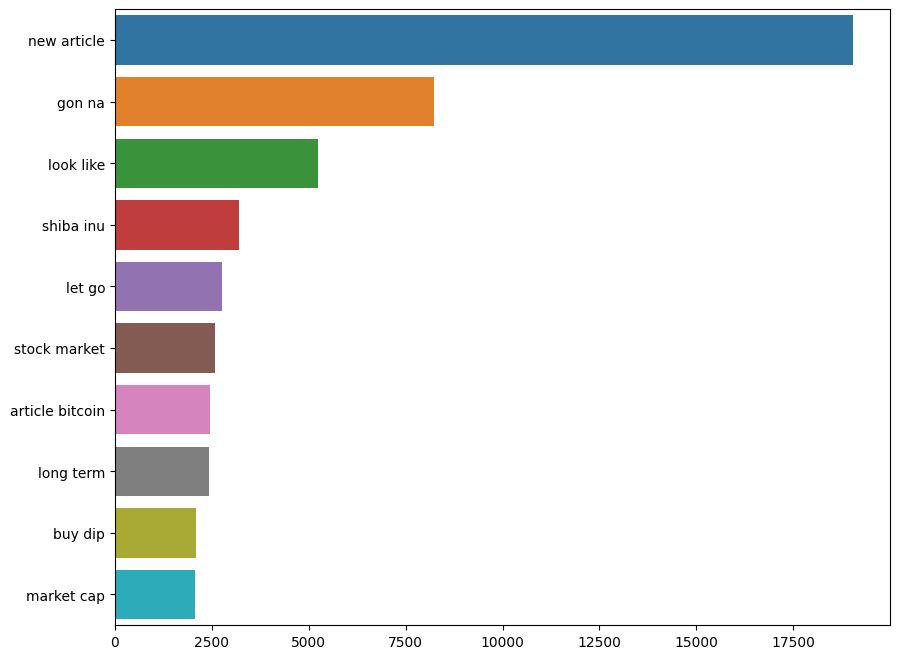

In [140]:
get_top_ngram(df['text_lemmatized'][df['label'] == 1], 2)

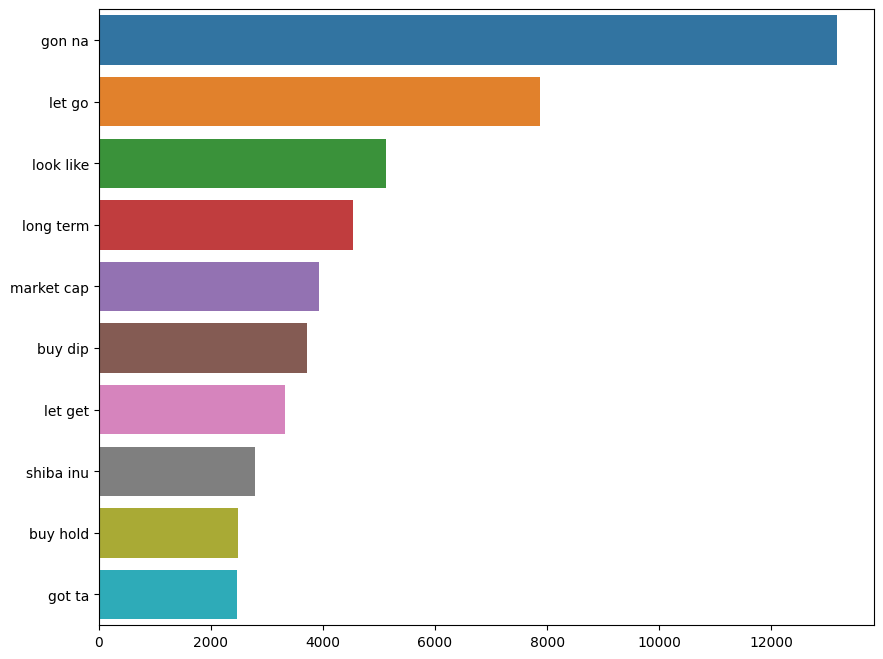

In [141]:
get_top_ngram(df['text_lemmatized'][df['label'] == 2], 2)

### 2-граммы для класса 2 выглядят логично: "покупаем", "лонгуем", "покупаем и держим", "вперёд"

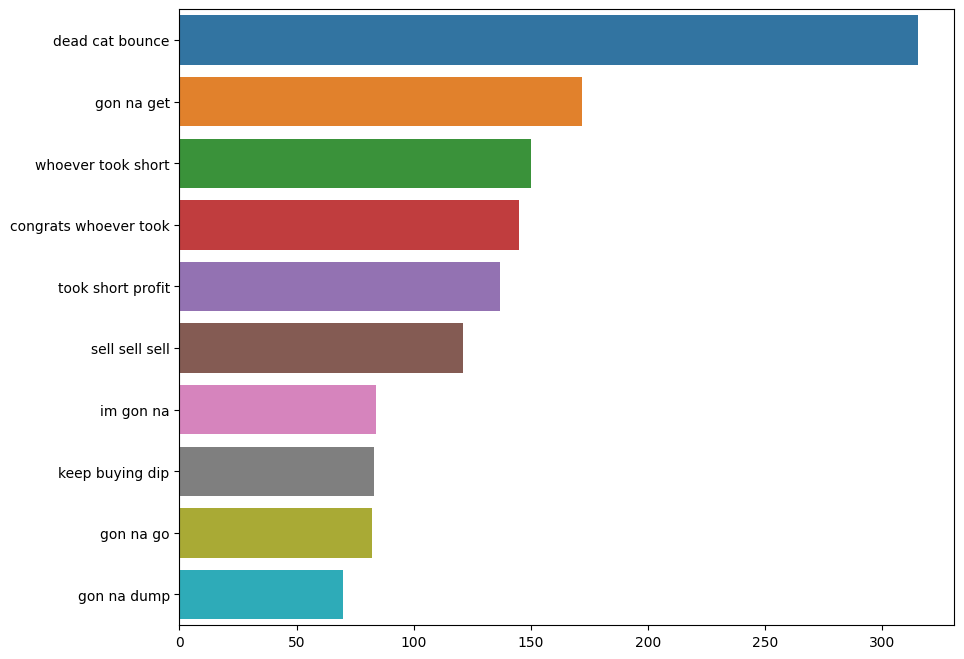

In [142]:
get_top_ngram(df['text_lemmatized'][df['label'] == 0], 3)

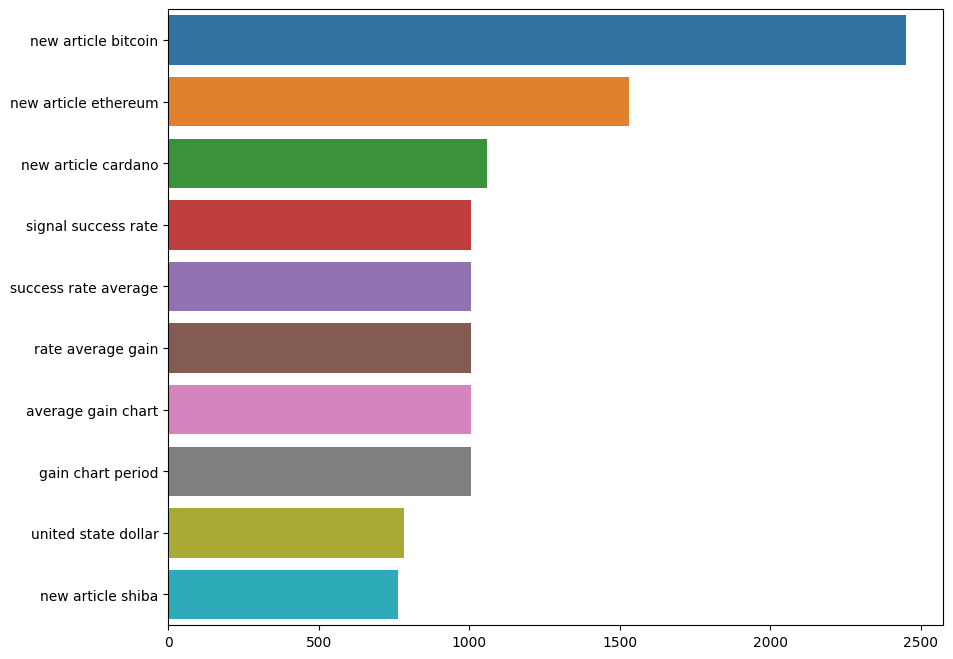

In [143]:
get_top_ngram(df['text_lemmatized'][df['label'] == 1], 3)

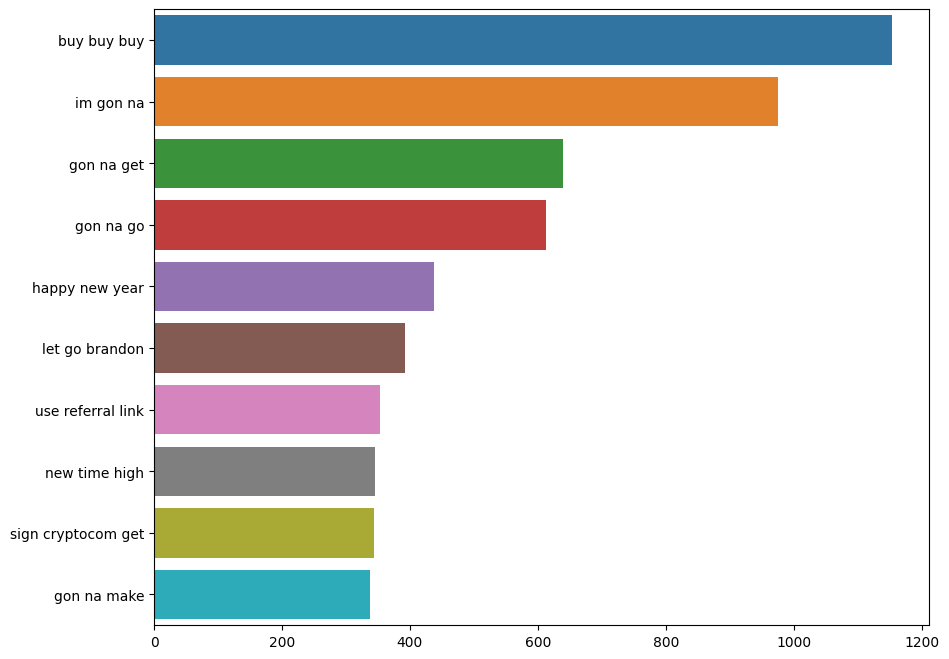

In [144]:
get_top_ngram(df['text_lemmatized'][df['label'] == 2], 3)

### Облака слов

In [149]:
def show_wordcloud(data):
    word_bag = []
    data.apply(lambda x: word_bag.extend(x))
    word_bag = list(filter(('>').__ne__, word_bag))
    word_bag = list(filter(('<').__ne__, word_bag))
    word_bag = list(filter(('number').__ne__, word_bag))
    wordcloud = WordCloud(
        background_color='white',
        stopwords=STOPWORDS,
        max_words=100,
        max_font_size=30,
        scale=3,
        random_state=1)

    wordcloud=wordcloud.generate(' '.join(word_bag))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')

    plt.imshow(wordcloud)
    plt.show()

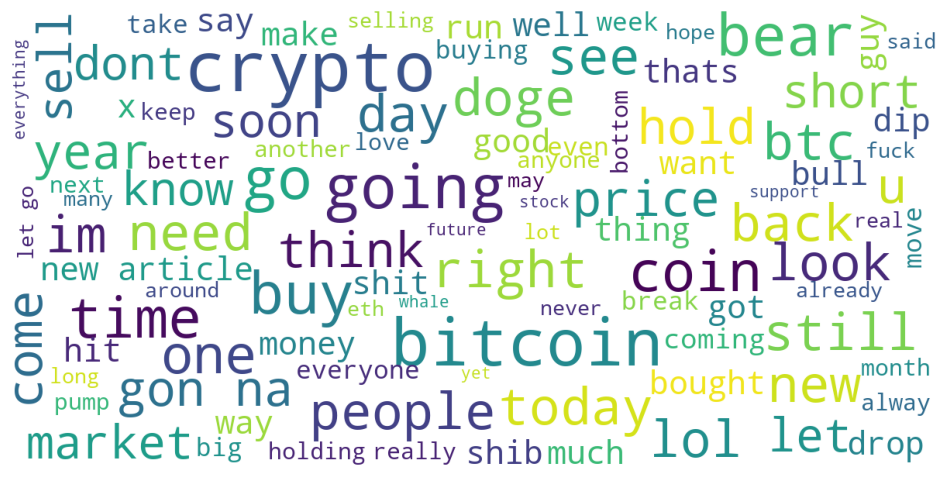

In [163]:
show_wordcloud(df['text_for_analysis'].sample(100_000, random_state=228))

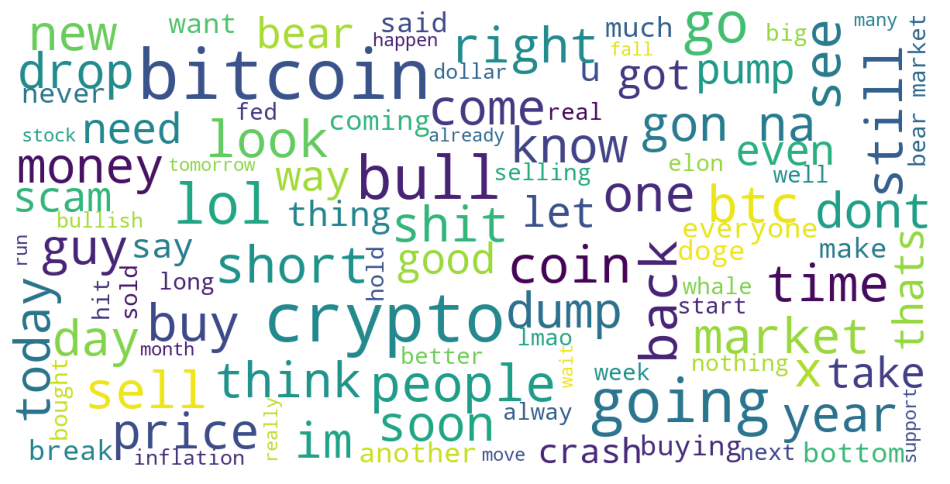

In [166]:
show_wordcloud(df.loc[df.label == 0]['text_for_analysis'].sample(100_000, random_state=228))

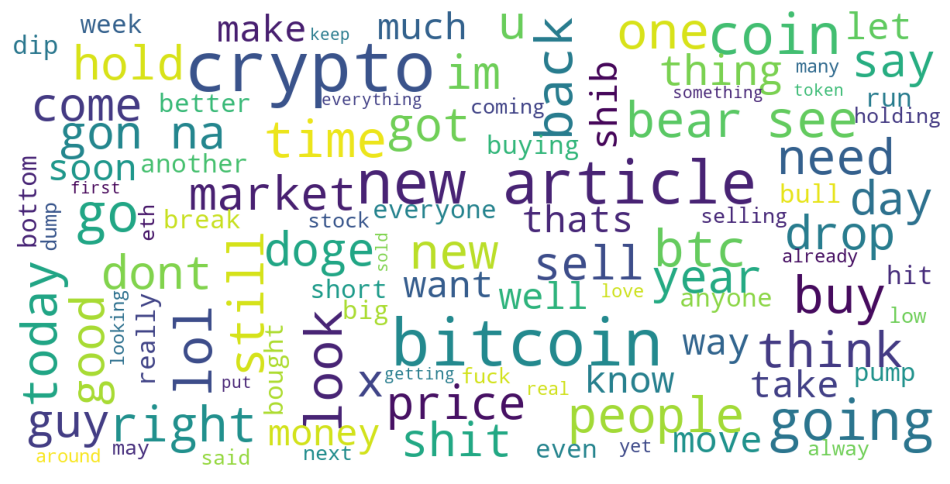

In [167]:
show_wordcloud(df.loc[df.label == 1]['text_for_analysis'].sample(100_000, random_state=228))

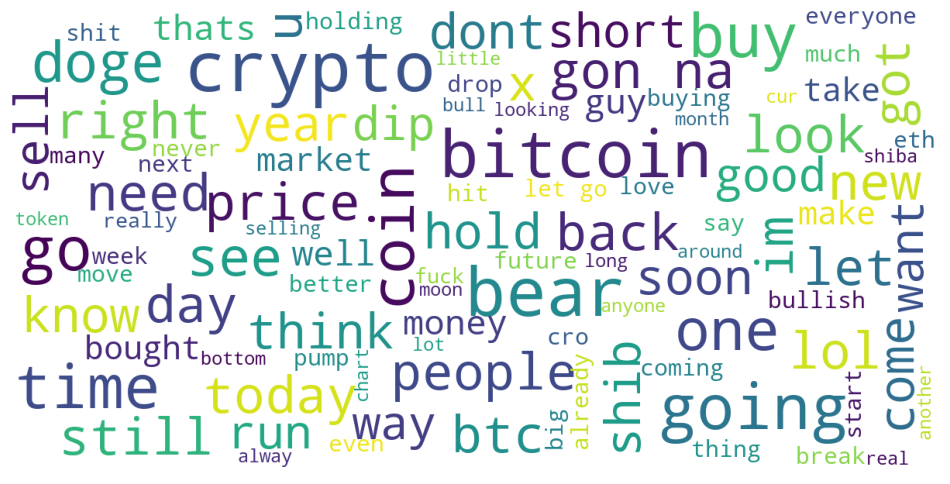

In [168]:
show_wordcloud(df.loc[df.label == 2]['text_for_analysis'].sample(100_000, random_state=228))

### Результат согласуется с полученным выше, однако вопросы вызывает качество разметки датасета. В корпусе явно есть твиты размеченные неправильно. Мы поинвестигали данный вопрос и обнаружили следующее: 
    1. Разметка осуществляется с помощью берта дообученного на корпус крипто твитов
    2. Модель часто определяет неимеющий смысловой нагрузки твит классом 2 (bullish)

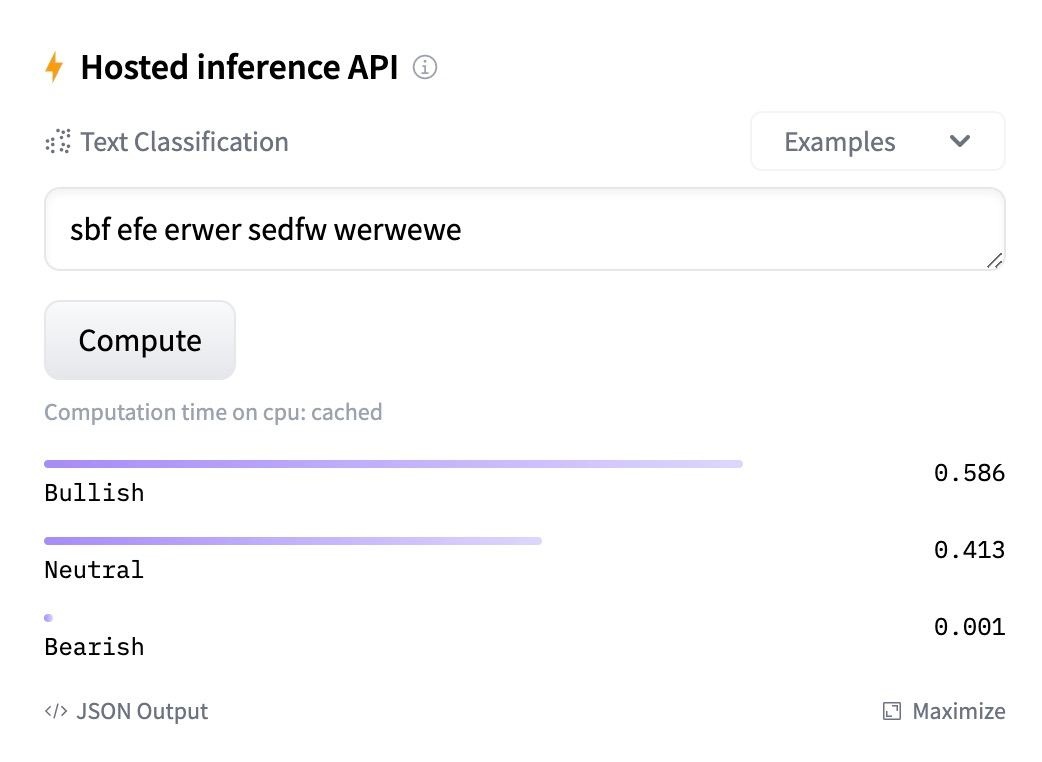

### Разметим тональность с помощью textblob

In [182]:
TextBlob('fuck you stupid idiot').sentiment.polarity

-0.6666666666666666

In [172]:
TextBlob('i am fond of you baby').sentiment.polarity

0.0

In [180]:
TextBlob('i kill your dog').sentiment.polarity

0.0

In [175]:
TextBlob('i like hamburger and cola').sentiment.polarity

0.0

In [176]:
TextBlob('i am stupid').sentiment.polarity

-0.7999999999999999

In [184]:
TextBlob('i am the luckiest boy in the world').sentiment.polarity

0.0

In [179]:
TextBlob('i win lottery').sentiment.polarity

0.8

### Если честно, у меня есть вопросы к оценкам этой модели, но ок)))

In [183]:
df['polarity'] = df['text'].progress_apply(lambda x: TextBlob(str(x)).sentiment.polarity)

  0%|          | 0/1326859 [00:00<?, ?it/s]

### Хотим проверить, отличаются ли как-то оценки полярности для представителей разных классов

In [185]:
#считаем ранговую корреляцию
df['polarity'].corr(df['label'], method='kendall')

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/scipy/stats/stats.py:4812: RuntimeWarning:

overflow encountered in long_scalars



0.04587440188317395

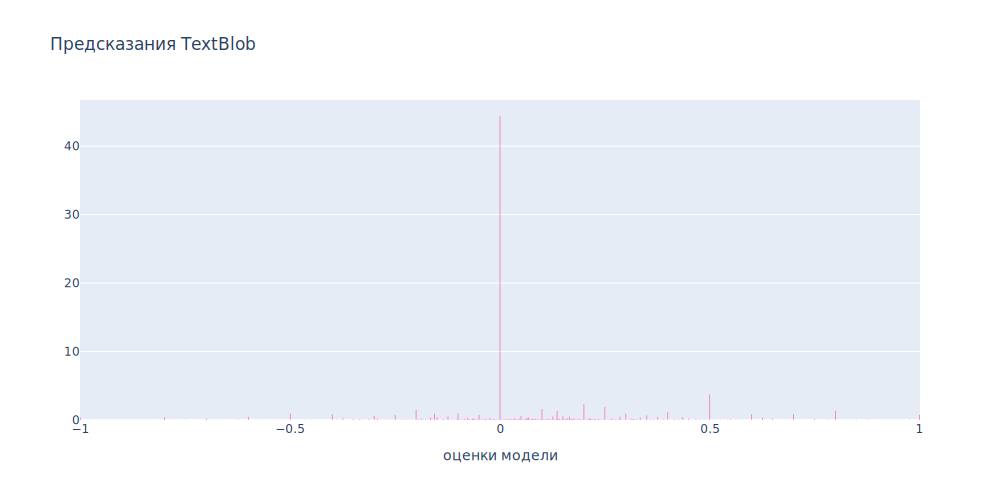

In [187]:
fig = go.Figure()
fig.add_trace(go.Histogram(
    x=df['polarity'],
    histnorm='percent',
    name='negative',
    marker_color='deeppink',
    opacity=0.75
))


fig.update_layout(
    title_text='Предсказания TextBlob', # title of plot
    xaxis_title_text='оценки модели', # xaxis label
    bargap=0.2, # gap between bars of adjacent location coordinates
    bargroupgap=0.1 # gap between bars of the same location coordinates
)

fig.show('svg', height=500, width=1000)

### Видим, что в 45% текстблоб не может определить полярность (возвращает 0)

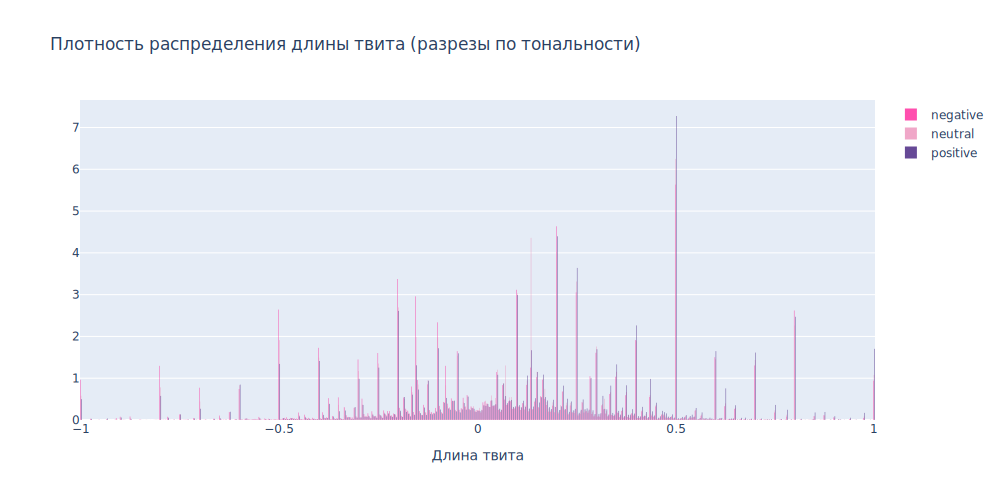

In [188]:
fig = go.Figure()
fig.add_trace(go.Histogram(
    x=df['polarity'][(df.label==0) & (df.polarity != 0)],
    histnorm='percent',
    name='negative',
    marker_color='deeppink',
    opacity=0.75
))
fig.add_trace(go.Histogram(
    x=df['polarity'][(df.label==1) & (df.polarity != 0)],
    histnorm='percent',
    name='neutral',
    marker_color='#EB89B5',
    opacity=0.75
))
fig.add_trace(go.Histogram(
    x=df['polarity'][(df.label==2) & (df.polarity != 0)],
    histnorm='percent',
    name='positive',
    marker_color='#330C73',
    opacity=0.75
))

fig.update_layout(
    title_text='Плотность распределения длины твита (разрезы по тональности)', # title of plot
    xaxis_title_text='Длина твита', # xaxis label
    bargap=0.2, # gap between bars of adjacent location coordinates
    bargroupgap=0.1 # gap between bars of the same location coordinates
)

fig.show('svg', height=500, width=1000)

### Визуально, распределения похожи друг с другом

### Выводы

### В рамках подготовки данных и их исследования было проделано следующее:

#### Подготовка данных

    1. Удалены дубликаты (несмотря на то, что авторами датасета было заявлено, что их нет, они есть)
    2. Твиты очищены на предмет:
        - лишних пробелов
        - удалены знаки пунктуации
        - цифры/числа
        - эмодзи
    3. Твиты токенизированы
    4. Удалены стоп-слова (стандартный набор nltk адаптирован под нашу задачу)
    5. Произведена лемматизация
    
#### Разведочный анализ 
    1. Произведён осмотр датасета, обнаружен дисбаланс классов (объектов нулевого класса ~10%)
    2. Посчитаны описательные статистики от длины твитов. Средняя длина ~8 слов вне зависимости от класса
    3. Проверили критерием согласия гипотезу о том, что выборки порождены разными распрелениями: нулевую гипотезу овтергаем на любом разумном уровне значимости
    4. Визуализировали распределения длины твитов
    5. Построены бар чарты для самых популярных слов, отмечена странность разметки датасета
    6. Построены 2, 3, 4-граммы: в тотале и по разрезах по классам
    7. Построены облака слов: в тотале и по разрезах по классам
    8. Через интерфейс huggingfaces подергали модель, которой размечался датасет (cryptobert), обнаружен баг: модель относит бесмысленные твиты к классу 2 
    9. Разметили корпус TextBlob и посчитали ранговую корреляцию между разметкой и полярностью: зависимости нет
    10. Визуализированы оценки полярности TextBlob в разрезе классов